# GSEA across neutrophil maturation stages


(based in the oficial pyGSEA tutorial https://gseapy.readthedocs.io/en/latest/singlecell_example.html)

This notebook performs **Gene Set Enrichment Analysis (GSEA)** to identify
biological processes associated with neutrophil maturation.

- **Input:** scRNA-seq AnnData (`.h5ad`) with neutrophils annotated by maturation stage
  (G1–G4 in bone marrow; G5a–c in blood).
- **Comparison:** WT vs KO within each maturation stage.
- **Gene sets:** Gene Ontology – Biological Process.

### Workflow
1. Preprocess and split the data by tissue and neutrophil stage.
2. Run GSEA independently for each stage.
3. Aggregate results and build NES matrices (GO terms × stages).
4. Annotate GO terms and visualize enrichment patterns using NES heatmaps.

### Output
- GSEA result tables per tissue.
- NES matrices and heatmaps summarizing pathway activity across stages.


# FUNCTIONS AND PACKS

In [19]:
import warnings
from numba.core.errors import NumbaDeprecationWarning

import requests
import time
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import os
import gseapy as gp

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

sc.set_figure_params(figsize=(5, 5))

In [20]:
def write_gct_cls(adata, outdir):
    """
    This function prepares input files for Gene Set Enrichment Analysis (GSEA)
    and runs GSEA separately for each neutrophil maturation stage.

    In summary, for each cell type present in `adata`, the function:
    1. Subsets the AnnData object by cell type.
    2. Generates GCT and CLS files following the Broad Institute GSEA format.
    3. Runs GSEA using GO Biological Process gene sets.
    4. Saves the GSEA results to disk and returns them as a dictionary.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing single-cell RNA-seq data.
        It must include:
        - `adata.obs['manual_celltype_annotation']`: cell type / maturation stage labels.
        - `adata.obs['condition']`: phenotype labels used for GSEA (e.g., WT vs KO).
        Expression values are expected to be already normalized and log-transformed
        in `adata.X`.

    outdir : str
        Path to the output directory where GCT, CLS, and GSEA result files
        will be written. The directory is created if it does not exist.

    Returns
    -------
    all_results : dict
        Dictionary where keys are cell types (e.g., G1, G2, G3, ...)
        and values are pandas DataFrames containing the GSEA results
        (`res.res2d`) for each corresponding cell type.
    """

    import time

    # Create output directory if it does not exist
    os.makedirs(outdir, exist_ok=True)

    # Dictionary to store GSEA results for each cell type
    all_results = {}

    # Iterate over each neutrophil maturation stage
    for cell in adata.obs.manual_celltype_annotation.unique():
        print(f"Processing cell type: {cell}")

        # Subset AnnData for the current cell type
        bdata = adata[adata.obs.manual_celltype_annotation == cell]

        # Extract condition labels (e.g., WT / KO) for CLS file
        groups = bdata.obs['condition'].tolist()
        cls_dict = bdata.obs['condition'].to_dict()

        # Expression matrix: genes as rows, cells as columns
        gs = bdata.to_df().T
        gs.index.name = "NAME"

        # Filter out genes with zero variance across conditions
        gs_std = gs.groupby(by=cls_dict, axis=1).std()
        gs = gs[gs_std.sum(axis=1) > 0]

        # Add a small constant to avoid zeros
        gs += 1e-8

        # Insert description column required by GCT format
        gs.insert(0, "Description", cell)

        # Define output file names
        outname = os.path.join(outdir, cell + ".gct")
        outcls = os.path.join(outdir, cell + ".cls")
        s_len = gs.shape[1] - 1  # number of samples (excluding Description)

        # Write GCT file
        with open(outname, "w") as correct:
            correct.write(f"#1.2\n{gs.shape[0]}\t{s_len}\n")
            gs.to_csv(correct, sep="\t")

        # Write CLS file (phenotype labels)
        with open(outcls, "w") as cl:
            cl.write(f"{len(groups)} 2 1\n# ko wt\n")
            cl.write(" ".join(groups) + "\n")

        print(f"GSEA run: {cell}")
        t1 = time.time()

        # Expression matrix used directly for GSEA (subset only)
        expression = bdata.to_df().T
        expression.index.name = "NAME"

        # Run GSEA using GO Biological Process gene sets
        res = gp.gsea(
            data=expression,
            gene_sets="GO_Biological_Process_2021",
            cls=groups,
            permutation_num=1000,
            permutation_type='phenotype',
            outdir=None,
            method='s2n',
            threads=16,
            seed=42,
            verbose=True
        )

        t2 = time.time()
        print(f"{cell} GSEA done in {t2-t1:.2f} sec")

        # Save GSEA results for the current cell type
        res.res2d.to_csv(f"{outdir}/{cell}_GSEA_results.csv")
        all_results[cell] = res.res2d

    return all_results

In [21]:
def concat_gsea_results(gsea_results, tissue):
    """
    This function aggregates Gene Set Enrichment Analysis (GSEA) results
    across all neutrophil maturation stages within a given tissue
    (bone marrow or blood).

    In the GSEA workflow, enrichment is computed separately for each
    cell type (e.g. G1–G5 subtypes). This function merges those
    cell-type–specific outputs into a single, tidy DataFrame, making it
    easier to:
      - compare enriched pathways across maturation stages,
      - perform downstream filtering or visualization,
      - export a unified results table per tissue.

    Parameters
    ----------
    gsea_results : dict
        Nested dictionary containing GSEA outputs, structured as:
        {'BM': {'G1': DataFrame,'G2': DataFrame, ...},'BL': {'G5a': DataFrame,'G5b': DataFrame,... }
        Each DataFrame corresponds to the `res.res2d` output from gseapy
        for one specific cell type.

    tissue : str
        Tissue identifier specifying which subset of results to concatenate.
        Expected values are: 'BM' for bone marrow, 'BL' for blood.

    Returns
    -------
    combined_df : pandas.DataFrame
        A single DataFrame containing GSEA results from all cell types
        within the selected tissue. An additional column, 'celltype',
        indicates the neutrophil maturation stage associated with each
        enriched gene set.
    """

    # Initialize an empty list to collect individual GSEA result DataFrames
    dfs = []

    # Iterate over each cell type and its corresponding GSEA DataFrame
    for celltype, df in gsea_results[tissue].items():
        # Create a copy to avoid modifying the original DataFrame
        df = df.copy()

        # Add a column identifying the cell type (neutrophil stage)
        df["celltype"] = celltype

        # Append the annotated DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single table
    combined_df = pd.concat(dfs, ignore_index=True)

    # Return the combined GSEA results for the selected tissue
    return combined_df


In [22]:
def build_nes_matrix_from_longdf(df_long, fdr_threshold=0.25, top_n=5):
    """
    Build a NES matrix (GO terms × cell types) from a long-format GSEA table.
    Keeps only significant terms (by FDR) and selects the top up- and down-regulated
    terms per cell type based on NES.
    """

    # Work on a copy and ensure clean column names
    df_long = df_long.copy()
    df_long.columns = df_long.columns.str.strip()

    # Ensure NES is numeric
    df_long['NES'] = pd.to_numeric(df_long['NES'], errors='coerce')

    # Filter by significance
    df_sig = df_long[df_long['FDR q-val'] < fdr_threshold]

    top_terms = []
    top_term_flags = {}

    # For each cell type, select top up- and down-regulated terms
    for celltype, group in df_sig.groupby('celltype'):
        top_up = group.sort_values('NES', ascending=False).head(top_n)
        top_down = group.sort_values('NES', ascending=True).head(top_n)
        top_df = pd.concat([top_up, top_down])
        top_terms.append(top_df)

        # Track which terms are top-ranked per cell type
        for term in top_df['Term']:
            top_term_flags[(term, celltype)] = True

    # Collect unique selected terms
    top_terms_df = pd.concat(top_terms)
    selected_terms = top_terms_df['Term'].unique()

    # Subset original data to selected terms only
    df_subset = df_long[df_long['Term'].isin(selected_terms)]

    # Build NES matrix: rows = GO terms, columns = cell types
    nes_matrix = df_subset.pivot_table(index='Term', columns='celltype', values='NES')
    nes_matrix = nes_matrix.astype(float)

    # Boolean matrix indicating whether a term is top-ranked in a given cell type
    all_celltypes = df_long['celltype'].unique()
    term_is_top = pd.DataFrame(False, index=nes_matrix.index, columns=all_celltypes)

    for (term, celltype), is_top in top_term_flags.items():
        if term in term_is_top.index and celltype in term_is_top.columns:
            term_is_top.loc[term, celltype] = True

    # Order terms by mean NES across cell types
    term_order = nes_matrix.mean(axis=1).sort_values(ascending=False).index
    nes_matrix = nes_matrix.loc[term_order]
    term_is_top = term_is_top.loc[term_order]

    return nes_matrix, term_is_top


def get_parents_resiliente(go_id):
    """
    Retrieve first-level parent GO terms for a given GO ID using the OLS API.
    Returns a list of parent labels, or ['None'] if the query fails.
    """

    try:
        # Query GO term metadata
        term_url = f"https://www.ebi.ac.uk/ols/api/ontologies/go/terms?obo_id={go_id}"
        r = requests.get(term_url)
        r.raise_for_status()

        term_json = r.json()
        if '_embedded' not in term_json or 'terms' not in term_json['_embedded']:
            return ["None"]

        terms = term_json['_embedded']['terms']
        if not terms:
            return ["None"]

        # Get parents link
        term = terms[0]
        parents_url = term.get('_links', {}).get('parents', {}).get('href', None)
        if not parents_url:
            return ["None"]

        # Query parent terms
        r_parents = requests.get(parents_url)
        r_parents.raise_for_status()

        parents_json = r_parents.json()
        if '_embedded' not in parents_json or 'terms' not in parents_json['_embedded']:
            return ["None"]

        parent_terms = parents_json['_embedded']['terms']
        parent_labels = [p.get('label', 'None') for p in parent_terms]

        time.sleep(0.3)  # API rate limiting
        return parent_labels if parent_labels else ["None"]

    except Exception as e:
        print(f"[!] Error fetching parents for {go_id}: {e}")
        return ["None"]


In [ ]:
def plot_nes_heatmap(
    nes_matrix,
    cmap='RdBu_r',
    center=0,
    width=12,
    height_per_term=0.37,
    font_scale=1.6,
    label_fontsize=16,
    tick_fontsize=14,
    title_fontsize=18,
    title="GSEA NES Heatmap (Top ±5 terms per celltype, FDR < 0.25)"
):
    """
    Plot a GSEA NES heatmap using only numeric NES values.

    This function is robust to:
    - Metadata columns (e.g. GO_ID, GO_Parent)
    - Object dtypes caused by mixed content
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    import textwrap
    import re
    import pandas as pd
    import numpy as np

    # --------------------------------------------------
    # 1) FORCE numeric-only matrix
    #    - Drop known metadata columns if present
    #    - Coerce everything else to numeric
    # --------------------------------------------------
    nes_numeric = nes_matrix.copy()

    # Remove metadata columns explicitly (if they exist)
    for col in ["GO_ID", "GO_Parent"]:
        if col in nes_numeric.columns:
            nes_numeric = nes_numeric.drop(columns=col)

    # Force numeric conversion (anything non-numeric -> NaN)
    nes_numeric = nes_numeric.apply(pd.to_numeric, errors="coerce")

    # Drop rows that became completely NaN
    nes_numeric = nes_numeric.dropna(how="all")

    # --------------------------------------------------
    # 2) Clean and wrap GO term labels
    # --------------------------------------------------
    def clean_and_wrap_labels(labels, width=40):
        cleaned = [re.sub(r'\s*\(GO:\d+\)', '', str(label)) for label in labels]
        wrapped = [
            '\n'.join(textwrap.wrap(label, width=width, break_long_words=False))
            for label in cleaned
        ]
        return wrapped

    sns.set_context("notebook", font_scale=font_scale)
    plt.close('all')

    wrapped_labels = clean_and_wrap_labels(nes_numeric.index, width=40)
    nes_numeric.index = wrapped_labels

    # --------------------------------------------------
    # 3) Dynamic figure height (poster-friendly)
    # --------------------------------------------------
    estimated_lines = sum(label.count('\n') + 1 for label in wrapped_labels)
    height = max(6, estimated_lines * height_per_term)

    # --------------------------------------------------
    # 4) Plot heatmap
    # --------------------------------------------------
    plt.figure(figsize=(width, height))
    ax = sns.heatmap(
        nes_numeric,
        cmap=cmap,
        center=center,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'NES'},
        vmin=-3,
        vmax=3
    )

    # --------------------------------------------------
    # 5) Styling
    # --------------------------------------------------
    ax.set_ylabel("GSEA Term", fontsize=label_fontsize)
    ax.set_xlabel("Cell Type", fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize)

    plt.tight_layout(pad=3)
    plt.show()


# LOAD AND PREPARE DATA

In [ ]:
# Load the AnnData object containing scRNA-seq data and DEGs results
adata = sc.read(f"/media/tahila/DADOS/HD/25_scNeutrofilos_/2506_scRNA_Neutrofilos_2/04.DEGs_MAST_output.h5ad")

# Filter out G0 cells, keeping only neutrophils from maturation stages G1–G5
adata = adata[adata.obs['manual_celltype_annotation'] != 'G0'].copy()

# Use SoupX-corrected counts as the expression matrix
adata.X = adata.layers['soupX_counts']

# Normalize total counts per cell and apply log-transformation
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#### Define ordered categories and colors for neutrophil maturation stages
group_order = ["G1", "G2", "G3", "G4", "G5a", "G5b", "G5c"]
colors_dict = {
    "G1": "#68009cff", "G2": "#ffea00ff", "G3": "#3c78d8ff", "G4": "#ff9900ff",
    "G5a": "#d786c4ff", "G5b": "#000000", "G5c": "#0097a7ff"
}

# Set the cell type annotation as an ordered categorical variable
adata.obs['manual_celltype_annotation'] = pd.Categorical(
    adata.obs['manual_celltype_annotation'], categories=group_order, ordered=True
)

# Store the corresponding colors for consistent plotting
adata.uns["manual_celltype_annotation_colors"] = [colors_dict[g] for g in group_order]

#### Split AnnData objects by experimental group and filter cell types
adatas = {}

# Bone marrow samples: include all neutrophil maturation stages
for group in ['BM_WT', 'BM_KO']:
    adatas[group] = {'adata': adata[adata.obs['Sample_grouped'] == group].copy()}

# Peripheral blood samples: include only G5 subtypes
for group in ['BL_WT', 'BL_KO']:
    mask = (
        (adata.obs['Sample_grouped'] == group) &
        (adata.obs['manual_celltype_annotation'].astype(str).str.startswith('G5'))
    )
    adatas[group] = {'adata': adata[mask].copy()}

#### Merge WT and KO samples by tissue
# batch_key=None avoids creating an additional batch annotation column
adatas['BL'] = {'adata': adatas['BL_WT']['adata'].concatenate(adatas['BL_KO']['adata'], batch_key=None)}
adatas['BM'] = {'adata': adatas['BM_WT']['adata'].concatenate(adatas['BM_KO']['adata'], batch_key=None)}

#### Further split each AnnData object by neutrophil maturation stage
for group, data in adatas.items():
    celltypes = data['adata'].obs['manual_celltype_annotation'].unique()

    for cell in celltypes:
        adatas[group][cell] = data['adata'][data['adata'].obs['manual_celltype_annotation'] == cell].copy()

# Define output directory for GSEA results and ensure it exists
outdir = "/home/tahila/scrna-seq-workflows/codes_and_notebooks/maybe/07.GSEA"
os.makedirs(outdir, exist_ok=True)


adata.X seems to be already log-transformed.
/tmp/ipykernel_313553/3318183044.py:46: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adatas['BL'] = {'adata': adatas['BL_WT']['adata'].concatenate(adatas['BL_KO']['adata'], batch_key=None)}
/tmp/ipykernel_313553/3318183044.py:47: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adatas['BM'] = {'adata': adatas['BM_WT']['adata'].concatenate(adatas['BM_KO']['adata'], batch_key=None)}


# GSEA EXECUTION

In [ ]:
## Generate GCT and CLS files and run GSEA
# prepares input files for Gene Set Enrichment Analysis (GSEA)
# and runs GSEA separately for each neutrophil maturation stage.

gsea_results = {}
for tissue in ['BM', 'BL']:
    gsea_results[tissue] = write_gct_cls(
        adatas[tissue]['adata'],
        f"{outdir}/GCT_CLS_files_{tissue}/"
    )



Processing cell type: G4


/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()
2025-12-24 10:16:36,290 [INFO] Parsing data files for GSEA.............................


GSEA run: G4


/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:16:36,569 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:16:36,611 [INFO] 5399 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:16:36,612 [INFO] 0637 gene_sets used for further statistical testing.....
2025-12-24 10:16:36,612 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:16:36,613 [INFO] Genes are converted to uppercase.
2025-12-24 10:16:45,883 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G4 GSEA done in 9.64 sec
Processing cell type: G1


2025-12-24 10:16:47,123 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:16:47,147 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:16:47,198 [INFO] 5412 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:16:47,199 [INFO] 0624 gene_sets used for further statistical testing.....
2025-12-24 10:16:47,199 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:16:47,200 [INFO] Genes are converted to uppercase.


GSEA run: G1


2025-12-24 10:16:49,142 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G1 GSEA done in 2.04 sec
Processing cell type: G2


2025-12-24 10:16:52,894 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:16:52,955 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:16:52,996 [INFO] 5398 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:16:52,996 [INFO] 0638 gene_sets used for further statistical testing.....
2025-12-24 10:16:52,997 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:16:52,997 [INFO] Genes are converted to uppercase.


GSEA run: G2


2025-12-24 10:16:56,005 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G2 GSEA done in 3.13 sec
Processing cell type: G5a


2025-12-24 10:17:09,716 [INFO] Parsing data files for GSEA.............................


GSEA run: G5a


/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:17:10,004 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:17:10,060 [INFO] 5396 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:17:10,061 [INFO] 0640 gene_sets used for further statistical testing.....
2025-12-24 10:17:10,061 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:17:10,062 [INFO] Genes are converted to uppercase.
2025-12-24 10:17:19,850 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G5a GSEA done in 10.20 sec
Processing cell type: G3


2025-12-24 10:17:28,013 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:17:28,164 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file


GSEA run: G3


2025-12-24 10:17:28,205 [INFO] 5396 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:17:28,205 [INFO] 0640 gene_sets used for further statistical testing.....
2025-12-24 10:17:28,205 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:17:28,206 [INFO] Genes are converted to uppercase.
2025-12-24 10:17:33,906 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G3 GSEA done in 5.92 sec
Processing cell type: G5b


2025-12-24 10:17:34,297 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:17:34,310 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:17:34,365 [INFO] 5466 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:17:34,365 [INFO] 0570 gene_sets used for further statistical testing.....
2025-12-24 10:17:34,366 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:17:34,366 [INFO] Genes are converted to uppercase.


GSEA run: G5b


2025-12-24 10:17:35,746 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G5b GSEA done in 1.46 sec
Processing cell type: G5c


2025-12-24 10:17:37,371 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:17:37,404 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:17:37,517 [INFO] 5401 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:17:37,517 [INFO] 0635 gene_sets used for further statistical testing.....
2025-12-24 10:17:37,518 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:17:37,518 [INFO] Genes are converted to uppercase.


GSEA run: G5c


2025-12-24 10:17:39,861 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G5c GSEA done in 2.50 sec
Processing cell type: G5a


2025-12-24 10:18:01,138 [INFO] Parsing data files for GSEA.............................


GSEA run: G5a


/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:18:01,542 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:18:01,581 [INFO] 5398 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:18:01,582 [INFO] 0638 gene_sets used for further statistical testing.....
2025-12-24 10:18:01,582 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:18:01,583 [INFO] Genes are converted to uppercase.
2025-12-24 10:18:15,103 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G5a GSEA done in 14.04 sec
Processing cell type: G5c


2025-12-24 10:18:18,345 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:18:18,398 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:18:18,437 [INFO] 5398 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:18:18,437 [INFO] 0638 gene_sets used for further statistical testing.....
2025-12-24 10:18:18,438 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:18:18,438 [INFO] Genes are converted to uppercase.


GSEA run: G5c


2025-12-24 10:18:21,241 [INFO] Congratulations. GSEApy ran successfully.................

/tmp/ipykernel_313553/459036861.py:58: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


G5c GSEA done in 2.92 sec
Processing cell type: G5b


2025-12-24 10:18:21,899 [INFO] Parsing data files for GSEA.............................
/home/tahila/miniconda3/envs/scRNA_NEW/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]
2025-12-24 10:18:21,916 [INFO] Enrichr library gene sets already downloaded in: /home/tahila/.cache/gseapy, use local file
2025-12-24 10:18:21,968 [INFO] 5437 gene_sets have been filtered out when max_size=500 and min_size=15
2025-12-24 10:18:21,969 [INFO] 0599 gene_sets used for further statistical testing.....
2025-12-24 10:18:21,969 [INFO] Start to run GSEA...Might take a while..................
2025-12-24 10:18:21,970 [INFO] Genes are converted to uppercase.


GSEA run: G5b


2025-12-24 10:18:23,481 [INFO] Congratulations. GSEApy ran successfully.................



G5b GSEA done in 1.60 sec


In [ ]:
# Concatenate GSEA results for bone marrow and blood
bm = concat_gsea_results(gsea_results, 'BM')
bl = concat_gsea_results(gsea_results, 'BL')

# Save the combined GSEA results to CSV files
bm.to_csv(f"{outdir}/gsea_combined_BM.csv", index=False)
bl.to_csv(f"{outdir}/gsea_combined_BL.csv", index=False)

bm.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype
0,gsea,negative regulation of programmed cell death (...,0.581017,2.439896,0.0,0.0,0.0,20/78,11.16%,NFKBIA;SH3RF2;PIM1;BCL3;PROK2;BCL2L1;XBP1;LTF;...,G4
1,gsea,I-kappaB kinase/NF-kappaB signaling (GO:0007249),0.697045,2.242535,0.0,0.000692,0.001,6/21,3.41%,NFKBIA;BCL3;TLR2;TLR4;CD14;BIRC3,G4
2,gsea,protein processing (GO:0016485),0.708198,2.214914,0.0,0.000922,0.002,11/20,14.21%,DDI2;GGT1;CASP4;ASPRV1;SRGN;ZMPSTE24;LONP2;ADA...,G4
3,gsea,negative regulation of apoptotic process (GO:0...,0.487828,2.131522,0.0,0.007264,0.019,23/104,11.66%,NFKBIA;SH3RF2;PIM1;BCL3;PROK2;BCL2L1;XBP1;LTF;...,G4
4,gsea,apoptotic process (GO:0006915),0.533264,2.127914,0.0,0.005812,0.019,17/55,13.34%,NFKBIA;PLSCR1;TLR2;CSRNP1;IER3;BCL2L1;CASP4;CD...,G4


In [ ]:
### Add a new column with the GO identifier extracted from the 'Term' field
# In GSEA outputs, the 'Term' column usually follows the format:
#   "biological process description (GO:XXXXXXX)"
# For downstream filtering, merging, or comparison across analyses,
# it is useful to have the GO ID explicitly stored in its own column.

# Helper function to extract the GO ID from the end of the 'Term' string
def extract_go_id(term):
    # Search for a pattern matching "(GO:XXXXXXX)", where X is a digit
    match = re.search(r"\(GO:\d{7}\)", term)
    # If a match is found, return only the GO ID without parentheses
    # Otherwise, return None
    return match.group(0).strip("()") if match else None

# Apply the GO ID extraction to both DataFrames,
# creating a new column called 'GO_ID'
bm['GO_ID'] = bm['Term'].apply(extract_go_id)
bl['GO_ID'] = bl['Term'].apply(extract_go_id)

bm.head(5)


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,celltype,GO_ID
0,gsea,negative regulation of programmed cell death (...,0.581017,2.439896,0.0,0.0,0.0,20/78,11.16%,NFKBIA;SH3RF2;PIM1;BCL3;PROK2;BCL2L1;XBP1;LTF;...,G4,GO:0043069
1,gsea,I-kappaB kinase/NF-kappaB signaling (GO:0007249),0.697045,2.242535,0.0,0.000692,0.001,6/21,3.41%,NFKBIA;BCL3;TLR2;TLR4;CD14;BIRC3,G4,GO:0007249
2,gsea,protein processing (GO:0016485),0.708198,2.214914,0.0,0.000922,0.002,11/20,14.21%,DDI2;GGT1;CASP4;ASPRV1;SRGN;ZMPSTE24;LONP2;ADA...,G4,GO:0016485
3,gsea,negative regulation of apoptotic process (GO:0...,0.487828,2.131522,0.0,0.007264,0.019,23/104,11.66%,NFKBIA;SH3RF2;PIM1;BCL3;PROK2;BCL2L1;XBP1;LTF;...,G4,GO:0043066
4,gsea,apoptotic process (GO:0006915),0.533264,2.127914,0.0,0.005812,0.019,17/55,13.34%,NFKBIA;PLSCR1;TLR2;CSRNP1;IER3;BCL2L1;CASP4;CD...,G4,GO:0006915


In [13]:
# Extract the GO ID from the end of the 'Term' column.
# The expected format is "(GO:XXXXXXX)", which is captured using a regular expression.
def extract_go_id(term):
    match = re.search(r"\(GO:\d{7}\)", term)
    return match.group(0).strip("()") if match else None

# Apply the GO ID extraction to each dataframe,
# creating a new column ('GO_ID') that can be used for downstream GO-based analyses.
bm['GO_ID'] = bm['Term'].apply(extract_go_id)
bl['GO_ID'] = bl['Term'].apply(extract_go_id)

In [43]:
## 1. Generate the NES matrix from the long-format GSEA results
# This step selects significantly enriched GO terms and builds a matrix
# with NES values (rows = GO terms, columns = cell types).
nes_matrix_bl, top_flags_bl = build_nes_matrix_from_longdf(bl)
nes_matrix_bm, top_flags_bm = build_nes_matrix_from_longdf(bm)

# Remove the column name that creates the extra header row
nes_matrix_bl.columns.name = None
nes_matrix_bl.index.name = None
nes_matrix_bm.columns.name = None
nes_matrix_bm.index.name = None

#### 2. Extract the GO ID from the index (GO term string) and add it as a new column
# The GO ID is captured using a regular expression matching the standard GO format.
nes_matrix_bm['GO_ID'] = [re.search(r'GO:\d{7}', term).group(0) for term in nes_matrix_bm.index]
nes_matrix_bl['GO_ID'] = [re.search(r'GO:\d{7}', term).group(0) for term in nes_matrix_bl.index]

#### 3. Add a column with the parent GO terms
# For each GO ID, query the ontology to retrieve its direct parent terms,
# enabling higher-level biological interpretation.
nes_matrix_bm['GO_Parent'] = nes_matrix_bm['GO_ID'].apply(get_parents_resiliente)
nes_matrix_bl['GO_Parent'] = nes_matrix_bl['GO_ID'].apply(get_parents_resiliente)

# Optional: export the annotated NES matrices for downstream analysis or visualization
nes_matrix_bm.to_csv(f"{outdir}/nes_matrix_parents_BM.csv")
nes_matrix_bl.to_csv(f"{outdir}/nes_matrix_parents_BL.csv")

nes_matrix_bl.head(3)

,G5a,G5b,G5c,GO_ID,GO_Parent
membrane organization (GO:0061024),1.947206,1.653861,1.910640,GO:0061024,[cellular component organization]
regulation of transcription initiation from RNA polymerase II promoter (GO:0060260),2.185546,1.419557,1.436742,GO:0060260,[regulation of DNA-templated transcription ini...
protein ubiquitination (GO:0016567),2.168395,0.824976,1.970189,GO:0016567,[protein modification by small protein conjuga...


# HEATMAP

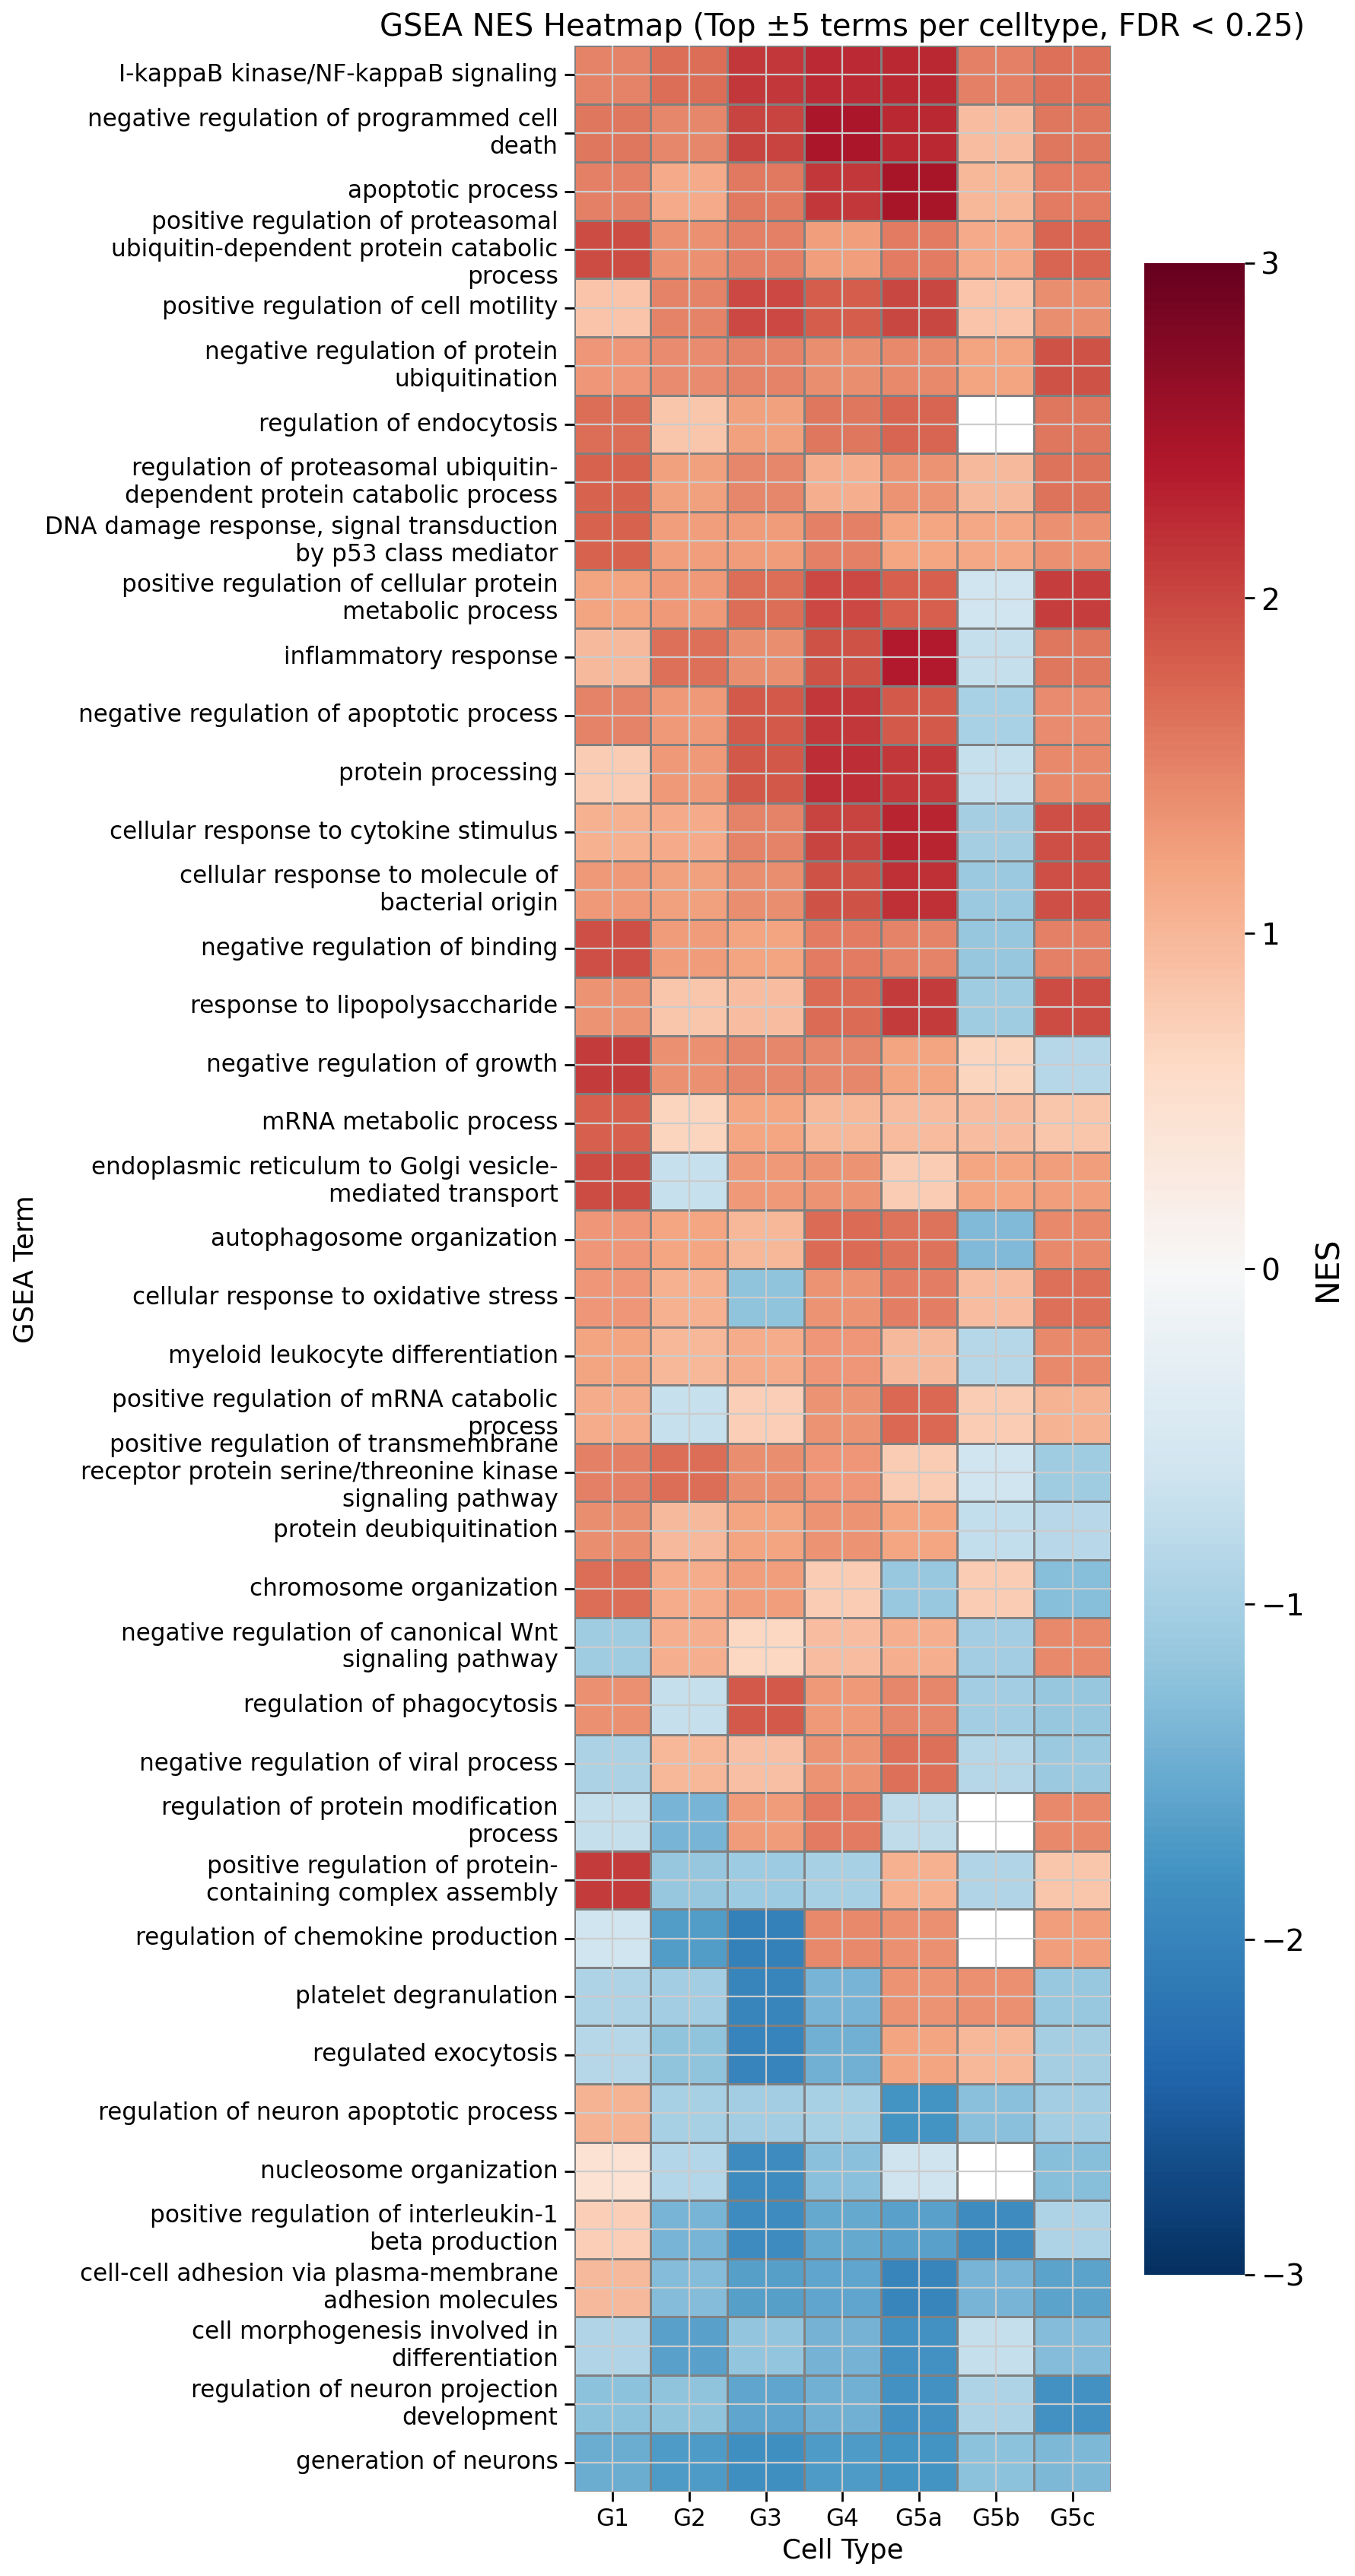

In [47]:
plot_nes_heatmap(nes_matrix_bm)